In [1]:
# Import các thư viện cần thiết
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from os import path
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from wordcloud import ImageColorGenerator
import re
import pickle
import joblib
import spacy
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import numpy as np
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
import datetime
import warnings
import gensim
# from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from bs4 import BeautifulSoup
from gensim.models import CoherenceModel
from gensim import corpora, models
# !pip install pyLDAvis Uncomment and run it if not installed
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
# Đọc dữ liệu từ file CSV
tweets = pd.read_csv("../Data/train_data.csv", encoding="ISO-8859-1")
# Loại bỏ các dòng có giá trị NaN trong cột 'text'
tweets = tweets.dropna(subset=['text'])
tweets = tweets.reset_index(drop=True)

In [4]:
# Chỉ chọn những tweet có nhãn 'Negative'
tweets = tweets[tweets.airline_sentiment == 'Negative']

In [5]:
# Đọc danh sách các stop-words liên quan đến lĩnh vực hàng không
stopwords_lda = pd.read_csv('../Train_LDA/stopwords_lda.csv')

# Hàm tiền xử lý văn bản
def preprocess(text):
    # Khởi tạo bộ từ dừng từ thư viện wordcloud
    stopwords = set(STOPWORDS)

    # Cập nhật thêm các từ dừng liên quan đến hàng không từ file
    stopwords.update([str(i).lower() for i in stopwords_lda.name])

    # Biểu thức chính quy để lọc các mention, hashtag và số chuyến bay
    mentions_filter = re.compile(r'(?<=\@)(\w+)')
    hashtags_filter = re.compile(r'(?<=\#)(\w+)')
    flight_numbers = re.compile(r'(flt\d*)')

    # Tìm các mentions, hashtag, số chuyến bay trong văn bản
    all_mentions = mentions_filter.findall(text.lower())
    all_hashtag = hashtags_filter.findall(text.lower())
    all_flights = flight_numbers.findall(text.lower())

    # Khởi tạo lemmatizer từ WordNet
    word_lemmatize = WordNetLemmatizer()

    # Hàm lemmatization cho các từ
    def lemm_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lemmatize.lemmatize(item,'v'))  # Lemmatize các từ ở dạng động từ
        return lemmatized

    # Hàm để loại bỏ emoji
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')

    text = deEmojify(text)  # Xử lý emoji
    soup = BeautifulSoup(text)  # Xử lý HTML
    text = soup.get_text()  # Lấy văn bản từ HTML

    # Loại bỏ dấu câu
    punc_text = [x.lower() for x in text if x not in string.punctuation]
    text = "".join(punc_text)

    # Tokenize văn bản
    word_tokens = nltk.word_tokenize(text)

    # Lọc các từ có độ dài từ 4 đến 15 ký tự
    filtered_tokens = [x for x in word_tokens if len(x)>4 and len(x)<15]

    # Áp dụng lemmatization và loại bỏ các từ không cần thiết
    tokens = lemm_tokens(filtered_tokens, word_lemmatize)
    all_tokens = [i for i in tokens if (i not in stopwords) and (i not in all_mentions)
                  and (i not in all_hashtag) and (i not in all_flights) and (not i.isdigit())]

    return all_tokens

In [6]:
# Tiền xử lý một ví dụ văn bản
text = """@Jenny @Joe and @Susan we are all very dissapointing in your service with the LONG delays
            for flt15539 560948 #notdoingthisanymore #dontflythem in New York to Chicago"""
preprocess(text)

['dissapointing', 'service', 'delay']

In [7]:
# Áp dụng hàm preprocess lên cột 'text' của dataframe và lưu kết quả vào cột 'token'
tweets['token']=tweets['text'].astype("string").map(preprocess)

In [8]:
# Loại bỏ các tweet trùng lặp dựa trên nội dung cột 'text'
tweets = tweets.drop_duplicates(subset=['text'], keep='first')
tweets = tweets.reset_index(drop=True)

In [9]:
# Hàm loại bỏ các dòng có cột 'token' trống
def remove_if_empty(df):
    empty_ids = df['token'].map(lambda i: len(i)) > 0
    idsToDelete = []
    for i in range(len(empty_ids)):
        if not empty_ids[i]:
            idsToDelete.append(i)
    for currentID in idsToDelete:
        df = df.drop(df[df.index == currentID].index[0])
    return df

# In kích thước của dữ liệu trước và sau khi loại bỏ các dòng trống
print(tweets.shape)
tweets = remove_if_empty(tweets)
print(tweets.shape)

(11990, 7)
(11477, 7)


In [10]:
tweets = tweets.reset_index(drop=True)

In [11]:
# Tiền xử lý các tài liệu (tweets) để xây dựng mô hình LDA
processed_docs = tweets['token']
id2word = gensim.corpora.Dictionary(processed_docs)  # Tạo từ điển
corpus = [id2word.doc2bow(text) for text in processed_docs]  # Chuyển các văn bản thành dạng BOW


In [12]:
# Lưu từ điển và corpus
id2word.save_as_text('../Train_LDA/dict.txt')
id2word.save('../Train_LDA/id2word.dict')

In [13]:
# Hàm tính toán độ phù hợp của mô hình LDA cho một khoảng số topic
def coherenceval(dictionary, corpus, texts, start, stop):
    c_val = []
    model_ls = []
    for num_topics in range(start, stop):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                num_topics=num_topics,
                                                id2word=id2word,
                                                random_state=123,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
        model_ls.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_val.append(coherencemodel.get_coherence())

    return model_ls, c_val

In [14]:
# Tính toán điểm Coherence cho mô hình LDA với số lượng chủ đề từ start đến stop
start = 1  # Số lượng chủ đề bắt đầu
stop = 15  # Số lượng chủ đề kết thúc

# Gọi hàm coherenceval để tính toán điểm Coherence cho mỗi số lượng chủ đề
model_list, coherence_values = coherenceval(dictionary=id2word,
                                            corpus=corpus,
                                            texts=processed_docs,
                                            start=start,
                                            stop=stop)

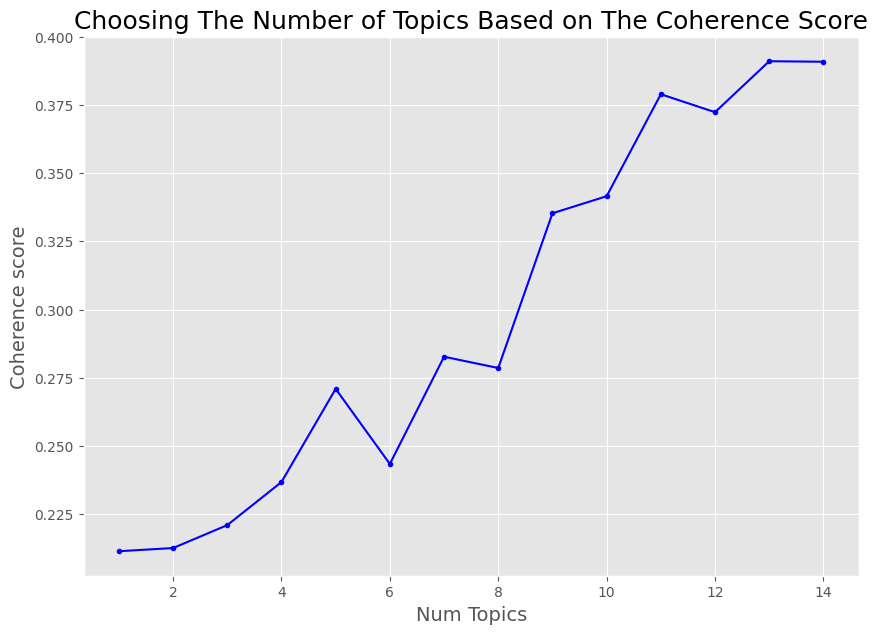

In [15]:
# Vẽ đồ thị để chọn số lượng chủ đề dựa trên điểm Coherence
x = range(start, stop)  # Tạo khoảng giá trị cho số lượng chủ đề
plt.figure(figsize=(10, 7))  # Đặt kích thước cho đồ thị
plt.style.use('ggplot')  # Sử dụng phong cách đồ thị 'ggplot'
plt.plot(x, coherence_values, color="blue", marker=".")  # Vẽ đồ thị với điểm Coherence
plt.xlabel("Num Topics", size=14)  # Đặt nhãn trục x là "Số lượng chủ đề"
plt.ylabel("Coherence score", size=14)  # Đặt nhãn trục y là "Điểm Coherence"
plt.title('Choosing The Number of Topics Based on The Coherence Score', size=18)  # Đặt tiêu đề cho đồ thị
plt.show()  # Hiển thị đồ thị

In [16]:
# Tính toán thời gian chạy của mô hình
# Xây dựng mô hình LDA với số lượng chủ đề = 8
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=8,  # Số lượng chủ đề
                                             alpha='auto',  # Hệ số alpha tự động
                                             eta='auto',  # Hệ số eta tự động
                                             iterations=125,  # Số vòng lặp huấn luyện
                                             per_word_topics=True)  # Xác định chủ đề cho từng từ

In [17]:
# In ra các chủ đề và từ khóa tương ứng
from pprint import pprint
print(lda_model4.print_topics())  # In ra các chủ đề của mô hình LDA


[(0, '0.113*"service" + 0.087*"customer" + 0.018*"website" + 0.013*"experience" + 0.011*"fly" + 0.011*"miles" + 0.010*"reach" + 0.009*"phone" + 0.009*"disappoint" + 0.008*"wait"'), (1, '0.040*"book" + 0.032*"change" + 0.025*"ticket" + 0.023*"problems" + 0.021*"experience" + 0.020*"travel" + 0.016*"cancel" + 0.013*"offer" + 0.011*"direct" + 0.010*"issue"'), (2, '0.033*"baggage" + 0.023*"charge" + 0.017*"handle" + 0.013*"start" + 0.010*"feel" + 0.009*"phone" + 0.009*"upgrade" + 0.009*"employees" + 0.008*"customers" + 0.008*"runway"'), (3, '0.083*"delay" + 0.057*"wait" + 0.032*"airport" + 0.027*"cancel" + 0.025*"phone" + 0.024*"answer" + 0.019*"staff" + 0.018*"number" + 0.017*"passengers" + 0.015*"arrive"'), (4, '0.038*"board" + 0.026*"issue" + 0.020*"service" + 0.018*"cancel" + 0.015*"customer" + 0.014*"online" + 0.014*"refund" + 0.013*"money" + 0.011*"sleep" + 0.010*"spend"'), (5, '0.085*"cancel" + 0.035*"refund" + 0.026*"response" + 0.023*"email" + 0.021*"rebook" + 0.019*"phone" + 0.01

In [18]:
# Tính toán Perplexity của mô hình (Đánh giá chất lượng mô hình, giá trị thấp hơn tốt hơn)
print('\nPerplexity: ', lda_model4.log_perplexity(corpus))

# Tính toán điểm Coherence của mô hình
coherence_model_lda = CoherenceModel(model=lda_model4, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()  # Lấy điểm Coherence
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.926382101188754

Coherence Score:  0.2838259559331193


In [19]:
# Lưu mô hình LDA đã huấn luyện
lda_model4.save('lda_model4.model')

In [20]:
# Tải lại dictionary đã lưu
id2word = corpora.Dictionary.load('../Train_LDA/id2word.dict')

# Kiểm tra với một tweet chưa thấy (unseen document)
unseen_document = "@united has the WORST customer experience ever! first the website was down, then the boarding and checkin processes w so complicated and slow"
# unseen_document = '@TK_HelpDesk @KuwaitAirports please see the thread. 11 passengers are stressed at your airport for 7 hours due to fight between 2 Airlines @KuwaitAirways @TurkishAirlines can you do something?? Humble request for a fast solution.'
# unseen_document = '''I didn't get my preferred seat. Was uncomfortable during the entire flight.'''
# unseen_document = '''the representative did not make any accommodation for the seconds  class ticket.'''
# unseen_document ='''Hi @airindia staff, i cancelled my ticket but no refund was provided please help'''

# Chuyển đổi tweet chưa thấy thành bow_vector
bow_vector = id2word.doc2bow(preprocess(unseen_document))

# Xác định các chủ đề của tweet chưa thấy
result = lda_model4.get_document_topics(bow_vector, minimum_probability=0.0)

# Chuyển kết quả thành từ điển và sắp xếp theo độ tương ứng
resultdict = dict(result)
orddict = sorted(resultdict, key=resultdict.get, reverse=True)

In [21]:
# Dựa vào giá trị chủ đề, in ra kết quả
Keymax = 1  # Lấy chủ đề có điểm cao nhất
if Keymax == 1:
    print('Delay Issue')  # Trường hợp chủ đề 1 là "Vấn đề trễ chuyến"
elif Keymax == 2:
    print('Reservation Issue')  # Trường hợp chủ đề 2 là "Vấn đề đặt vé"
elif Keymax == 3:
    print('Baggage Issue')  # Trường hợp chủ đề 3 là "Vấn đề hành lý"
elif Keymax == 4:
    print('Customer Service')  # Trường hợp chủ đề 4 là "Dịch vụ khách hàng"
elif Keymax == 5:
    print('Reschedule Issue')  # Trường hợp chủ đề 5 là "Vấn đề thay đổi lịch bay"
elif Keymax == 6 or Keymax == 7:
    print('Phone or Online Booking Issue')  # Trường hợp chủ đề 6 và 7 là "Vấn đề đặt vé qua điện thoại hoặc trực tuyến"
else:
    print('Refund Issues')  # Các trường hợp khác là "Vấn đề hoàn tiền"
print("\n")

# In ra các chủ đề và từ khóa tương ứng
for index, score in resultdict.items():
    print("Score: {}\n Topic: {}\n Keywords:{} \n".format(score, index+1, lda_model4.print_topic(index)))

Delay Issue


Score: 0.41164517402648926
 Topic: 1
 Keywords:0.113*"service" + 0.087*"customer" + 0.018*"website" + 0.013*"experience" + 0.011*"fly" + 0.011*"miles" + 0.010*"reach" + 0.009*"phone" + 0.009*"disappoint" + 0.008*"wait" 

Score: 0.013769579119980335
 Topic: 2
 Keywords:0.040*"book" + 0.032*"change" + 0.025*"ticket" + 0.023*"problems" + 0.021*"experience" + 0.020*"travel" + 0.016*"cancel" + 0.013*"offer" + 0.011*"direct" + 0.010*"issue" 

Score: 0.012182026170194149
 Topic: 3
 Keywords:0.033*"baggage" + 0.023*"charge" + 0.017*"handle" + 0.013*"start" + 0.010*"feel" + 0.009*"phone" + 0.009*"upgrade" + 0.009*"employees" + 0.008*"customers" + 0.008*"runway" 

Score: 0.016062112525105476
 Topic: 4
 Keywords:0.083*"delay" + 0.057*"wait" + 0.032*"airport" + 0.027*"cancel" + 0.025*"phone" + 0.024*"answer" + 0.019*"staff" + 0.018*"number" + 0.017*"passengers" + 0.015*"arrive" 

Score: 0.5065416693687439
 Topic: 5
 Keywords:0.038*"board" + 0.026*"issue" + 0.020*"service" + 0.018*"ca

In [22]:
# Cài đặt pyLDAvis để hiển thị trực quan kết quả của mô hình LDA
import pyLDAvis
import pyLDAvis.gensim_models

# Kích hoạt chế độ hiển thị trực quan trong Jupyter notebook
pyLDAvis.enable_notebook()

# Chuẩn bị dữ liệu cho pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_model4, corpus, id2word, sort_topics=False)

# Lưu kết quả trực quan vào file HTML
pyLDAvis.save_html(vis, '../Train_LDA/ldaviz.html')

# Hiển thị kết quả trực quan trong Jupyter notebook
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.171367  0.028307       1        1  15.203258
1     -0.076483  0.123573       2        1  13.759849
2      0.136022  0.100518       3        1   8.421118
3      0.099027 -0.191836       4        1  14.780330
4     -0.080890 -0.062527       5        1  12.969154
5     -0.063496 -0.077970       6        1  15.468142
6      0.052731 -0.024516       7        1   9.946613
7      0.104456  0.104452       8        1   9.451536, topic_info=          Term         Freq        Total Category  logprob  loglift
29     service  1190.000000  1190.000000  Default  30.0000  30.0000
84    customer   983.000000   983.000000  Default  29.0000  29.0000
281       wait   546.000000   546.000000  Default  28.0000  28.0000
93       delay  1152.000000  1152.000000  Default  27.0000  27.0000
83     luggage   325.000000   325.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
118     change    36.996850   466.613652   Topic8  -4.9052  -0.1757
223      class    25.731431   101.202331   Topic8  -5.2683   0.9896
78     provide    24.470782   116.293836   Topic8  -5.3185   0.8004
2       refund    25.757700   504.541267   Topic8  -5.2673  -0.6159
429  attendant    22.524536    63.096305   Topic8  -5.4014   1.3289

[552 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2228      4  0.932998      45min
669       3  0.922813     absurd
3785      4  0.941001    abysmal
346       1  0.055137     accept
346       5  0.110274     accept
...     ...       ...        ...
1627      2  0.840732      worry
1627      4  0.124553      worry
616       3  0.854262  worthless
231       1  0.928629      youll
231       5  0.037145      youll

[1268 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [23]:
# Hiển thị file HTML của pyLDAvis trong Jupyter notebook
from IPython.display import HTML
HTML(filename='../Train_LDA/ldaviz.html')